In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numba import jit, int32, njit, uint8, vectorize, guvectorize
import cython
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [60]:
with Image.open("precipitation-europe-monthly/06_m0kGXXI.png") as im:
    june = np.asarray(im.convert('HSV'))
with Image.open("precipitation-europe-monthly/07_FtLmcoE.png") as im:
    july = np.asarray(im.convert('HSV'))
with Image.open("precipitation-europe-monthly/08_srcd6PS.png") as im:
    august = np.asarray(im.convert('HSV'))
with Image.open("precipitation-europe-monthly/align_temperature_to_precipitation.png") as im:
    temp = np.asarray(im.convert('HSV'))

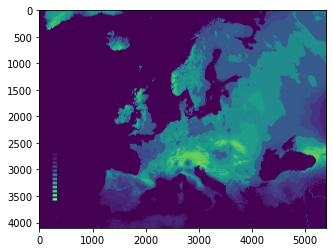

In [45]:
plt.imshow(june[:,:,0])

In [103]:
avg = "max"
if avg == "sum":
    combo = june.copy()
    x1=(np.sin(np.radians(june[:,:,0].reshape((-1,))))
                            +np.sin(np.radians(july[:,:,0].reshape((-1,))))
                            +np.sin(np.radians(august[:,:,0].reshape((-1,)))))
    x2=(np.cos(np.radians(june[:,:,0].reshape((-1,))))
                            +np.cos(np.radians(july[:,:,0].reshape((-1,))))
                            +np.cos(np.radians(august[:,:,0].reshape((-1,)))))
    combo[:,:,0] = np.arctan2(x1,x2).reshape(combo[:,:,0].shape)

    #combo = june + july + august
    #combo = combo / 3
elif avg == "prod":
    tmp1 = np.asarray(Image.fromarray(june, "HSV").convert(mode='RGB'))
    tmp2 = np.asarray(Image.fromarray(july, "HSV").convert(mode='RGB'))
    tmp3 = np.asarray(Image.fromarray(august, "HSV").convert(mode='RGB'))
    combo = june * july * august
    combo = np.cbrt(combo)
    combo = np.asarray(Image.fromarray(august, "RGB").convert(mode='HSV'))
elif avg == "max":
    combo = np.maximum(june, july)
    combo = np.maximum(august, combo)
# Learn mapping from H to S and V from july, the middle month
h_s = LinearRegression().fit(july[:,:,0].reshape((-1, 1)), july[:,:,1].reshape((-1, 1)))
h_v = LinearRegression().fit(july[:,:,0].reshape((-1, 1)), july[:,:,2].reshape((-1, 1)))
combo[:,:,1] = h_s.predict(combo[:,:,0].reshape((-1, 1))).reshape(combo[:,:,1].shape)
combo[:,:,2] = h_v.predict(combo[:,:,0].reshape((-1, 1))).reshape(combo[:,:,2].shape)
combo = np.uint8(combo)
np.max(combo)

In [117]:
#tmp1 = np.asarray(Image.fromarray(june, "HSV").convert(mode='RGB'))
h_s = LinearRegression().fit(june[:,:,1:].reshape((-1, 2)), june[:,:,0].reshape((-1, 1)))
h_v = LinearRegression().fit(june[:,:,1].reshape((-1, 1)), june[:,:,2].reshape((-1, 1)))
print(h_s.score(june[:,:,1:].reshape((-1, 2)), june[:,:,0].reshape((-1, 1))))
print(h_v.score(june[:,:,1].reshape((-1, 1)), june[:,:,2].reshape((-1, 1))))

1.0
0.17431743604789407


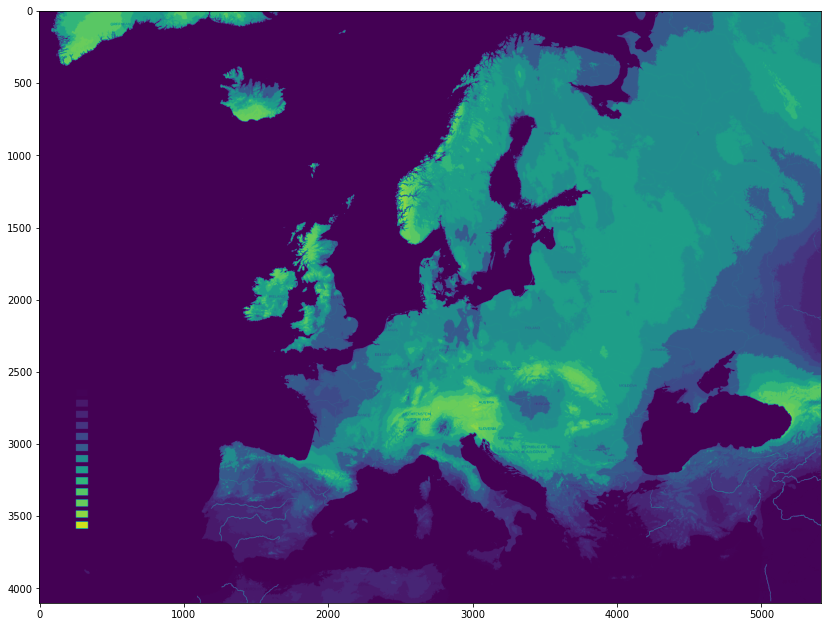

In [105]:
plt.figure(figsize=(14,14))
plt.imshow(combo[:,:,0])

In [106]:
combo2 = Image.fromarray(combo, "HSV").convert(mode='RGB')
combo2 = np.asarray(combo2)

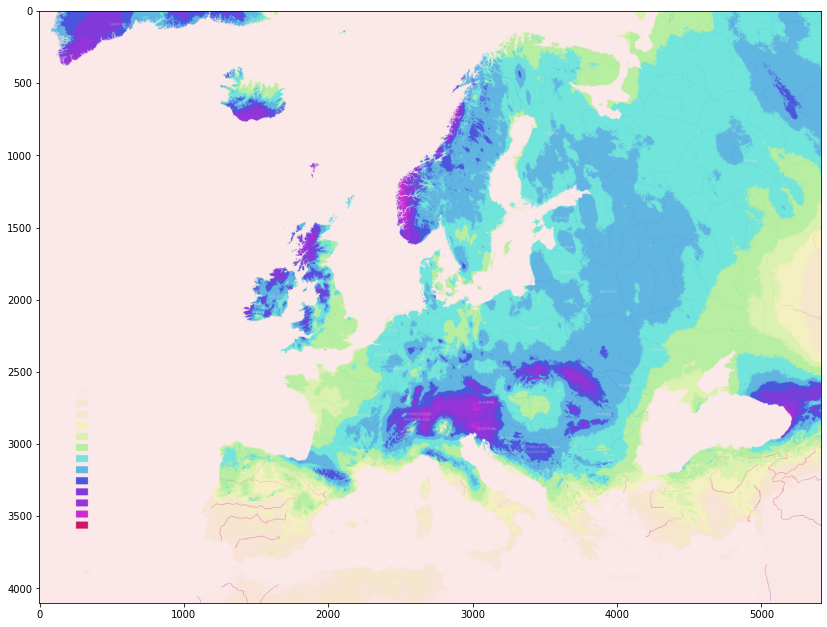

In [107]:
plt.figure(figsize=(14,14))
plt.imshow(combo2)

In [ ]:
I = numpy.asarray(PIL.Image.open('test.jpg'))
im = PIL.Image.fromarray(numpy.uint8(I))

Second attempt

In [118]:
def mapping_v_c(x): #vector of length 3
    if x == [241,150,144]:
        return 0 # <= 10
    elif x == [236,173,128]:
        return 1 # 10-20
    elif x == [255,211,139]:
        return 2 # 20-30
    elif x == [255,245,130]:
        return 3 # 30-40
    elif x == [214,249,148]:
        return 4 # 40-50
    elif x == [160,239,129]:
        return 5 # 50-65
    elif x == [106,228,218]:
        return 6 # 65-80
    elif x == [106,178,219]:
        return 7 # 80-100
    elif x == [118,127,255]:
        return 8 # 100-120
    elif x == [177,114,255]:
        return 9 # 120-150
    elif x == [209,135,255]:
        return 10 # 150-200
    elif x == [242,141,245]:
        return 11 # 200-300
    elif x == [245,119,17]:
        return 12 # >300

In [10]:
#@jit
%load_ext cython
%%cython -a
def eq(x, y):
    return x[0]==y[0] and x[1]==y[1] and x[2]==y[2]

#@guvectorize(['void(uint8[:])'], '(n,3)->(n)')
def mapping_vec_value(x, res): #vector of length 3
    #print(x)
    if eq(x , np.array([255, 255, 255], dtype=np.uint8)):
        return -1
    elif eq(x , np.array([241,150,144], dtype=np.uint8)):
        return 5 # <= 10
    elif eq(x , np.array([236,173,128], dtype=np.uint8)):
        return 15 # 10-20
    elif eq(x , np.array([255,211,139], dtype=np.uint8)):
        return 25 # 20-30
    elif eq(x , np.array([255,245,130], dtype=np.uint8)):
        return 35 # 30-40
    elif eq(x , np.array([214,249,148], dtype=np.uint8)):
        return 45 # 40-50
    elif eq(x , np.array([160,239,129], dtype=np.uint8)):
        return 58 # 50-65
    elif eq(x , np.array([106,228,218], dtype=np.uint8)):
        return 72 # 65-80
    elif eq(x , np.array([106,178,219], dtype=np.uint8)):
        return 90 # 80-100
    elif eq(x , np.array([118,127,255], dtype=np.uint8)):
        return 110 # 100-120
    elif eq(x , np.array([177,114,255], dtype=np.uint8)):
        return 135 # 120-150
    elif eq(x , np.array([209,135,255], dtype=np.uint8)):
        return 175 # 150-200
    elif eq(x , np.array([242,141,245], dtype=np.uint8)):
        return 250 # 200-300
    elif eq(x , np.array([245,119,17], dtype=np.uint8)):
        return 320 # >300
    else:
        return -10

@jit(uint8[:](int32))
def mapping_value_vec(x): #vector of length 3
    #print(x)
    if x<-10:
        return np.array([0,0,0], dtype=np.uint8)
    elif x<0:
        return np.array([255, 255, 255], dtype=np.uint8)
    elif x<10:
        return np.array([241,150,144], dtype=np.uint8)
    elif x<20:
        return np.array([236,173,128], dtype=np.uint8)
    elif x<30:
        return np.array([255,211,139], dtype=np.uint8)
    elif x<40:
        return np.array([255,245,130], dtype=np.uint8)
    elif x<50:
        return np.array([214,249,148], dtype=np.uint8)
    elif x<65:
        return np.array([160,239,129], dtype=np.uint8)
    elif x<80:
        return np.array([106,228,218], dtype=np.uint8)
    elif x<100:
        return np.array([106,178,219], dtype=np.uint8)
    elif x<120:
        return np.array([118,127,255], dtype=np.uint8)
    elif x<150:
        return np.array([177,114,255], dtype=np.uint8)
    elif x<200:
        return np.array([209,135,255], dtype=np.uint8)
    elif x<300:
        return np.array([242,141,245], dtype=np.uint8)
    else:
        return np.array([245,119,17], dtype=np.uint8)

#@njit(int32[:,:,:](uint8[:,:,:]))
def vec_mapping_vec_value(arr):
    tmp = arr.reshape((-1, 3))
    res = np.zeros((len(tmp), 1))
    for i in range(len(arr)):
        res[i] = mapping_vec_value(tmp[i])
    return res.reshape((arr.shape[0], arr.shape[1], 1)).astype(np.int32)

def vec_mapping_value_vec(arr):
    tmp = arr.reshape((-1,))
    res = np.zeros((len(tmp), 3))
    for i in range(len(arr)):
        res[i] = mapping_value_vec(tmp[i])
    return res.reshape((arr.shape[0], arr.shape[1], 3)).astype(np.uint8)

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


UsageError: Line magic function `%%cython` not found.


In [141]:
with Image.open("precipitation-europe-monthly/06_m0kGXXI.png") as im:
    june = np.asarray(im.convert('RGB'))
with Image.open("precipitation-europe-monthly/07_FtLmcoE.png") as im:
    july = np.asarray(im.convert('RGB'))
with Image.open("precipitation-europe-monthly/08_srcd6PS.png") as im:
    august = np.asarray(im.convert('RGB'))
with Image.open("precipitation-europe-monthly/align_temperature_to_precipitation.png") as im:
    temp = np.asarray(im.convert('RGB'))

In [219]:
june2 = vec_mapping_vec_value(june.copy())
june3 = vec_mapping_value_vec(june2)

In [220]:
eq(np.array([1,2,3]), np.array([1,2,3]))

True

In [222]:
print(june[2000, 2000])
print(june2[2000, 2000])
print(june3[2000, 2000])
np.where(june2!=0)

[106 228 218]
[0]
[0 0 0]


(array([0, 0, 0, ..., 0, 0, 0]),
 array([   0,    1,    2, ..., 4097, 4098, 4099]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [203]:
uniq

array([  0, 106, 118, 127, 128, 130, 139, 173, 178, 211, 218, 219, 228,
       236, 245, 255], dtype=uint8)

In [207]:
np.unique(june3.flatten(), return_counts=True)
#plt.hist(june3.flatten(), bins=list(range(255)))

(array([  0, 106, 118, 127, 128, 130, 139, 173, 178, 211, 218, 219, 228,
        236, 245, 255], dtype=uint8),
 array([66555300,     1057,        5,        5,        1,       38,
              12,        1,      743,       12,      314,      743,
             314,        1,       38,     9016]))

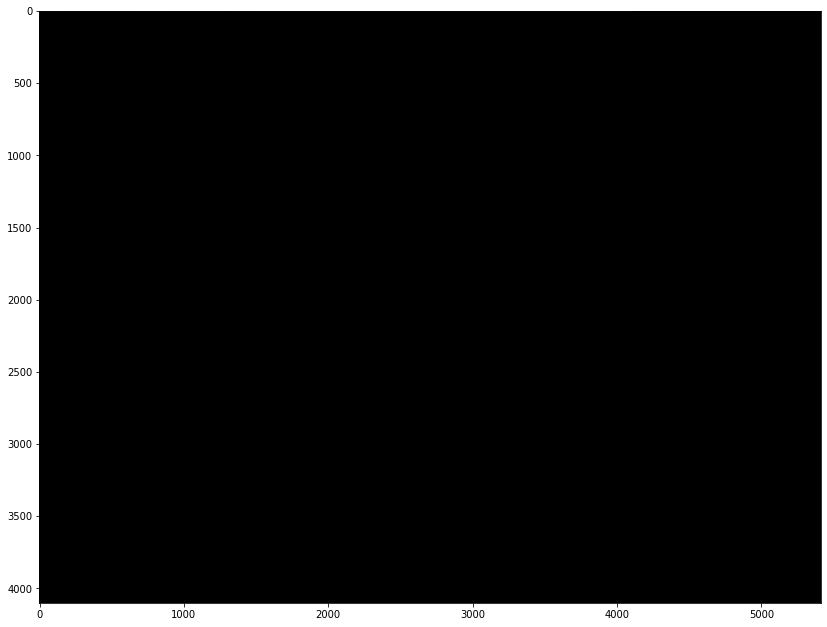

In [197]:
plt.figure(figsize=(14,14))
plt.imshow(june3.astype(float)/255)

# THIRD WAY: OPENCV

In [57]:
def propagate(array, coords, value, amount=2):
    array[coords[0]-amount:coords[0]+1+amount,
         coords[1]-amount:coords[1]+1+amount,
         coords[2]-amount:coords[2]+1+amount,] = value

lut_rgb_to_val = np.zeros((256,256,256), dtype=np.int32)
lut_rgb_to_val[:128,:128,:128] = 800
lut_rgb_to_val[128:,128:,128:] = 500
propagate(lut_rgb_to_val, [241,150,144], 5)
propagate(lut_rgb_to_val, [236,173,128], 15)
propagate(lut_rgb_to_val, [255,211,139], 25)
propagate(lut_rgb_to_val, [255,245,130], 35)
propagate(lut_rgb_to_val, [214,249,148], 45)
propagate(lut_rgb_to_val, [160,239,129], 58)
propagate(lut_rgb_to_val, [106,228,218], 72)
propagate(lut_rgb_to_val, [106,178,219], 90)
propagate(lut_rgb_to_val, [118,127,255], 110)
propagate(lut_rgb_to_val, [177,114,255], 135)
propagate(lut_rgb_to_val, [209,135,255], 175)
propagate(lut_rgb_to_val, [242,141,245], 250)
propagate(lut_rgb_to_val, [245,119,17], 320)
# lut_rgb_to_val[241,150,144] = 5
# lut_rgb_to_val[236,173,128] = 15
# lut_rgb_to_val[255,211,139] = 25
# lut_rgb_to_val[255,245,130] = 35
# lut_rgb_to_val[214,249,148] = 45
# lut_rgb_to_val[160,239,129] = 58
# lut_rgb_to_val[106,228,218] = 72
# lut_rgb_to_val[106,178,219] = 90
# lut_rgb_to_val[118,127,255] = 110
# lut_rgb_to_val[177,114,255] = 135
# lut_rgb_to_val[209,135,255] = 175
# lut_rgb_to_val[242,141,245] = 250
# lut_rgb_to_val[245,119,17] = 320

lut_val_to_rgb = np.zeros((801,3), dtype=np.uint8)
lut_val_to_rgb[800] = [0,0,0]
lut_val_to_rgb[:800] = [255,255,255]
lut_val_to_rgb[:500] = [245,119,17]
lut_val_to_rgb[:300] = [242,141,245]
lut_val_to_rgb[:200] = [209,135,255]
lut_val_to_rgb[:150] = [177,114,255]
lut_val_to_rgb[:120] = [118,127,255]
lut_val_to_rgb[:100] = [106,178,219]
lut_val_to_rgb[:80] = [106,228,218]
lut_val_to_rgb[:65] = [160,239,129]
lut_val_to_rgb[:50] = [214,249,148]
lut_val_to_rgb[:40] = [255,245,130] 
lut_val_to_rgb[:30] = [255,211,139]
lut_val_to_rgb[:20] = [236,173,128]
lut_val_to_rgb[:10] = [241,150,144]

In [44]:
#@jit([int32(uint8[:])])
def rgb_to_val(x):
    return lut_rgb_to_val[x[0], x[1], x[2]]

@njit([uint8[:](int32)])
def val_to_rgb(x):
    #print(x)
    return lut_val_to_rgb[x].copy()

In [14]:
with Image.open("precipitation-europe-monthly/06_m0kGXXI.png") as im:
    june = np.asarray(im.convert('RGB'))
with Image.open("precipitation-europe-monthly/07_FtLmcoE.png") as im:
    july = np.asarray(im.convert('RGB'))
with Image.open("precipitation-europe-monthly/08_srcd6PS.png") as im:
    august = np.asarray(im.convert('RGB'))
with Image.open("precipitation-europe-monthly/align_temperature_to_precipitation.png") as im:
    temp = np.asarray(im.convert('RGB'))

In [51]:
def apply_func(func, array):
    ls = []
    for x in array.reshape((array.shape[0]*array.shape[1], -1)):
        ls.append(func(x))
    return np.concatenate(ls).reshape((array.shape[0], array.shape[1], -1))

In [74]:
june_score = np.apply_along_axis(rgb_to_val, 1, june.reshape((-1, 3))).reshape((june.shape[0], june.shape[1], 1))
july_score = np.apply_along_axis(rgb_to_val, 1, july.reshape((-1, 3))).reshape((july.shape[0], july.shape[1], 1))
august_score = np.apply_along_axis(rgb_to_val, 1, august.reshape((-1, 3))).reshape((august.shape[0], august.shape[1], 1))

In [75]:
average_score = june_score + july_score + august_score
average_score = average_score / 3
average_score = average_score.astype(np.int32)

In [76]:
print(average_score.shape)
average = apply_func(val_to_rgb, average_score.reshape((-1)))
average = average.reshape(august.shape)

(4100, 5412, 1)


In [42]:
average = np.vectorize(val_to_rgb)(average_score.reshape((-1))).reshape((august.shape[0], august.shape[1], 3))

ValueError: setting an array element with a sequence.

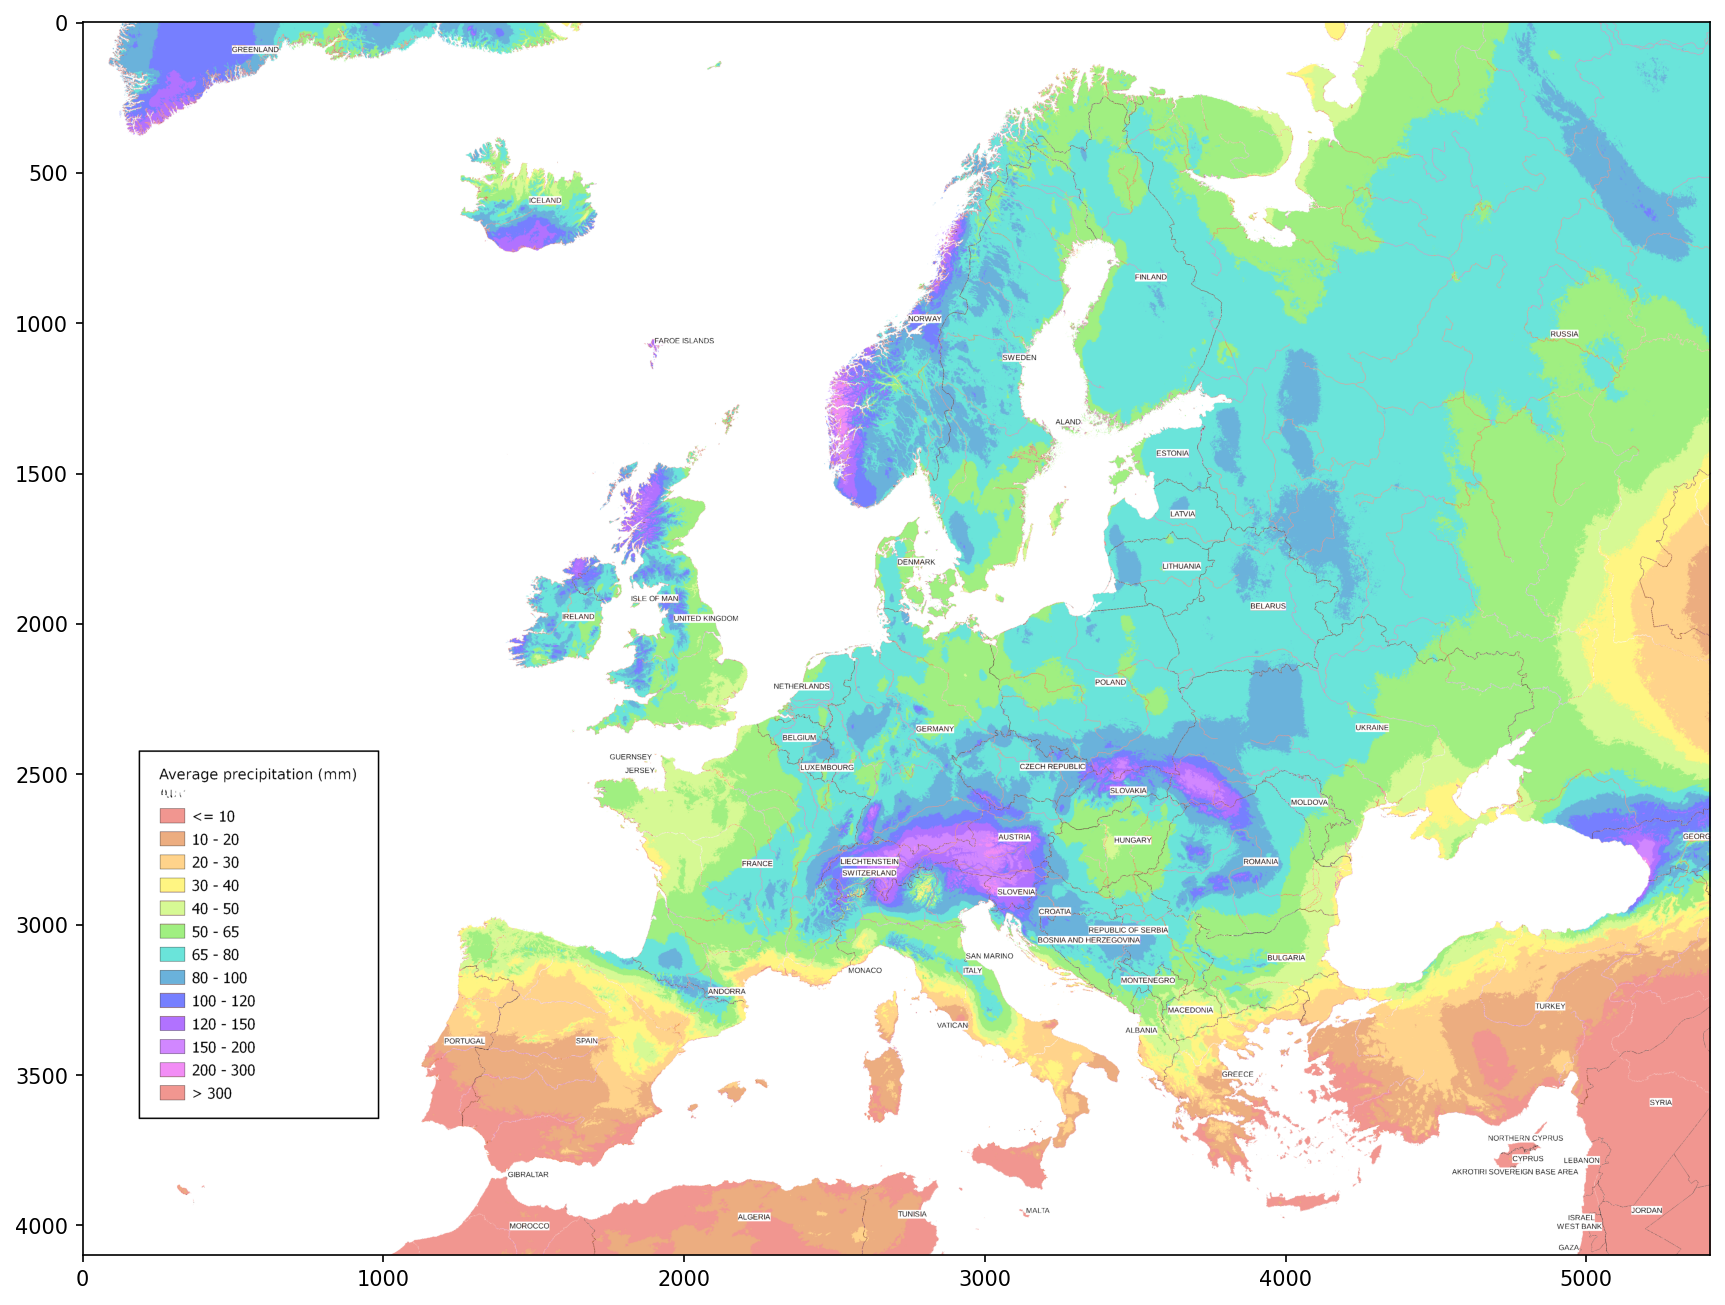

In [79]:
plt.figure(figsize=(14,14), dpi=150)
plt.imshow(average)

In [72]:
july_score[2500, 2000]

array([500], dtype=int32)

In [73]:
july[2500, 2000]

array([214, 249, 149], dtype=uint8)